In [52]:
import numpy as np
import math
import scipy as sp
from scipy import optimize
from numpy import genfromtxt
import pandas as pd 
import glob
import pymc as pm
import arviz as az
import statistics as stats
import matplotlib.pyplot as plt
import os,sys

In [53]:
# getting the name of the directory
# where the this file is present.
# current = os.path.dirname(os.path.realpath(__file__))
current = os.path.dirname(os.getcwd())
 
# Getting the parent directory name
# where the current directory is present.
# parent = os.path.dirname(os.path.dirname(current))
parent = current
print(parent)
#/Users/pizarror/IDM

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

from IDM_model.src import model_functions as mf

/Users/pizarror/mturk


In [54]:
def read_load_data(subject='23_IDM_0144',fn='/tmp',alpha0=1.0,cols=[]):
    df = pd.read_csv(fn)
    # remove practice trials
    df = df.loc[df['cdd_trial_type']=='task']
    # insert probability as choice into data
    # cols = ['cdd_trial_resp.corr','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
    # also returns percent_reward which we do not need here
    data = mf.get_data(df,cols,alpha_hat=alpha0)[0]
    data['subject'] = subject
    # vn = data['cdd_immed_amt'].to_list()
    # vr = data['cdd_delay_amt'].to_list()
    # tn = data['cdd_immed_wait'].to_list()
    # tr = data['cdd_delay_wait'].to_list()
    # choice = data['cdd_trial_resp.corr'].to_list()
    return data # vn,vr,tn,tr,choice

## Complete Pooling

Complete pooling ignores the group-level information and considers all data as belonging to the same category. All groups are described with the same model. 

We are using complete pooling to generate priors for when we implement a higherarchical bayesian model.

### Load data

We will load the data from all participants so we can run the modeling schema

In [56]:

# Takes about 16 seconds

# we will change this when we change utility to 1st level analysis (or split)
utility_dir = '/Volumes/UCDN/datasets/IDM/utility/'
save_dir = '/Volumes/UCDN/datasets/IDM/BH/csv'
subjs = sorted(glob.glob(os.path.join(utility_dir,'23_IDM_*')))
task = 'cdd'
# VNa,VRa,TNa,TRa,Cha = [[]]*5
cols = ['cdd_trial_resp.corr','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
data = pd.DataFrame(columns=['subject']+cols)

for s in subjs:
    subject = os.path.basename(s)
    fn  = os.path.join(s,task,'{}_{}.csv'.format(os.path.basename(s),task))
    if os.path.exists(fn):
        # SSA (Ben's smaller sooner amount) is vn (value_null)
        # LLA (Ben's larger later amount) is vr (value_reward)
        # SSD (Ben's smaller sooner delay) is tn (time_null)
        # LLD (Ben's larger later delay) is tr (time_reward)
        # y_pool (Ben's) is choice 
        # vn,vr,tn,tr,choice = read_load_data(fn=fn,alpha0=1.0)
        subj_data = read_load_data(subject=subject,fn=fn,alpha0=1.0,cols=cols)
        data = pd.concat([data,subj_data],ignore_index=True)
        # VNa = VNa + vn
        # VRa = VRa + vr
        # TNa = TNa + tn
        # TRa = TRa + tr
        # Cha = Cha + choice

print(data)





           subject  cdd_trial_resp.corr  cdd_immed_amt  cdd_delay_amt   
0      23_IDM_0001                  1.0            5.0           26.0  \
1      23_IDM_0001                  1.0            2.0           22.0   
2      23_IDM_0001                  0.0            2.0            6.0   
3      23_IDM_0001                  0.0           15.0           15.0   
4      23_IDM_0001                  1.0           15.0           55.0   
...            ...                  ...            ...            ...   
14299  23_IDM_0149                  1.0            2.0           12.0   
14300  23_IDM_0149                  0.0           20.0           24.0   
14301  23_IDM_0149                  0.0            2.0           41.0   
14302  23_IDM_0149                  1.0           10.0           65.0   
14303  23_IDM_0149                  0.0           20.0           25.0   

       cdd_immed_wait  cdd_delay_wait  alpha  
0                 0.0            29.0    1.0  
1                 0.0        

### 1. Estimate pooled model

Now we can run this completely model to get a prior for when we run the next round of BH model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 222 seconds.


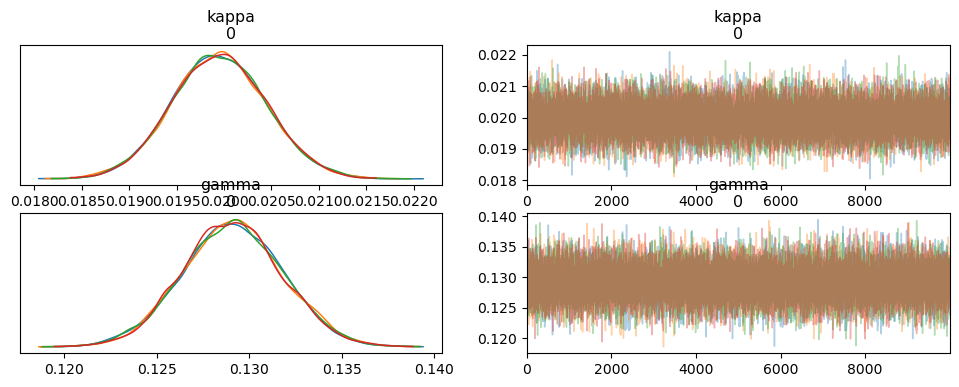

In [57]:
# This is a pool model. This is not good for our case. It will just get one k and one b for each session, but it won't incorporate everyone's data. Returns wonky values as far as I remember.

# takes approximately 10 minutes

with pm.Model() as model_pool:

    kappa = pm.Beta('kappa',mu=0.3,sigma=0.2,shape=1)#np.size(SSA)) #mu=0.1, mu=0.07,sd=0.1 05
    gamma = pm.HalfNormal('gamma',sigma=0.5,shape=1)#np.size(SSA)) #mu=0.1, mu=0.005,sd=0.01 mu=0,
    
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma * ( data['cdd_delay_amt'].values/(1+(kappa*data['cdd_delay_wait'].values)) - 
                                                                   data['cdd_immed_amt'].values/(1+(kappa*data['cdd_immed_wait'].values)) ))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=data['cdd_trial_resp.corr'])

    trace_pool = pm.sample(10000, tune=10000, cores=4,target_accept=0.99)


# Call the trace whatever you like. This just saves it. You don't want to run a whole model and then accidentally x-out your window or refresh or something and lose it all!
az.plot_trace(trace_pool, var_names=["kappa","gamma"],compact=False)
# This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
Summary= az.summary(trace_pool,round_to=10)
# Again, call it what you want (yeah - call it what you want tooooo)
fn = os.path.join(save_dir,"completely_pooled_model.csv")
Summary.to_csv(fn)

In [59]:
fn = os.path.join(save_dir,'completely_pooled_model.csv')
pool_model = pd.read_csv(fn,index_col=0)

mu_kappa,std_kappa = pool_model.loc['kappa[0]','mean'],pool_model.loc['kappa[0]','sd']
mu_gamma,std_gamma = pool_model.loc['gamma[0]','mean'],pool_model.loc['gamma[0]','sd']

print('For kappa, use the following (mu,sigma) : ({},{})'.format(mu_kappa, std_kappa))
print('For gamma, use the following (mu,sigma) : ({},{})'.format(mu_gamma, std_gamma))

For kappa, use the following (mu,sigma) : (0.0199494192,0.0004967748)
For gamma, use the following (mu,sigma) : (0.1290928433,0.0027119263)


### 2. Simple Hierarchical Model

Use the posterior from the completely pooled model to define the priors for the inidividual


In [60]:
subjects = data['subject'].unique()
subjects = subjects[:10]
print(subjects)
data = data.loc[data['subject'].isin(subjects)]


['23_IDM_0001' '23_IDM_0002' '23_IDM_0003' '23_IDM_0004' '23_IDM_0005'
 '23_IDM_0006' '23_IDM_0007' '23_IDM_0008' '23_IDM_0009' '23_IDM_0010']


[0 1 2 3 4 5 6 7 8]
Working on modeling for subject : 23_IDM_0001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 30 seconds.


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0001.csv
Working on modeling for subject : 23_IDM_0002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 58 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 8067 divergences after tuning. Increase `target_accept` or reparameterize.


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0002.csv
Working on modeling for subject : 23_IDM_0003


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 32 seconds.


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0003.csv
Working on modeling for subject : 23_IDM_0004


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0004.csv
Working on modeling for subject : 23_IDM_0005


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 29 seconds.


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0005.csv
Working on modeling for subject : 23_IDM_0006


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0006.csv
Working on modeling for subject : 23_IDM_0007


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 29 seconds.


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0007.csv
Working on modeling for subject : 23_IDM_0008


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0008.csv
Working on modeling for subject : 23_IDM_0009


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 75 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 13136 divergences after tuning. Increase `target_accept` or reparameterize.


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/pool_as_prior_s23_IDM_0009.csv


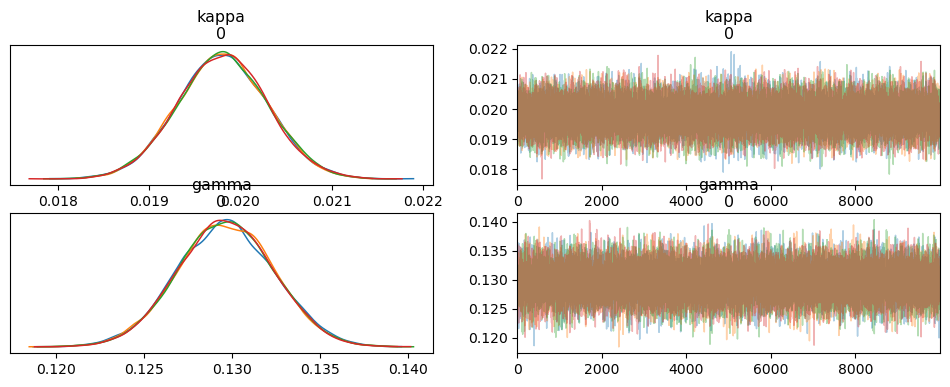

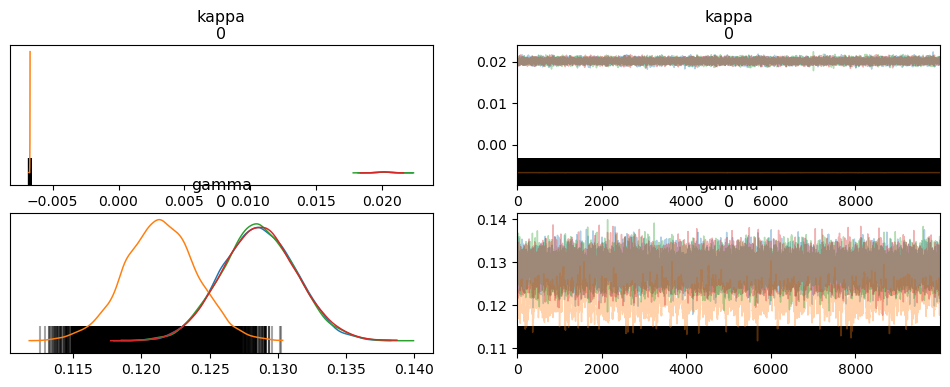

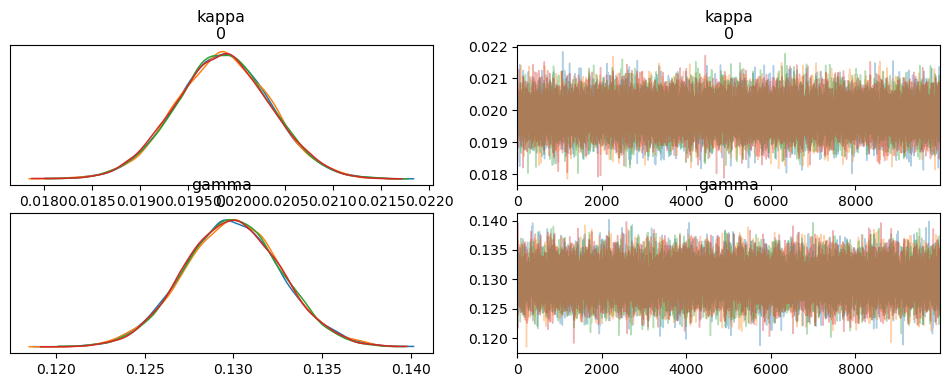

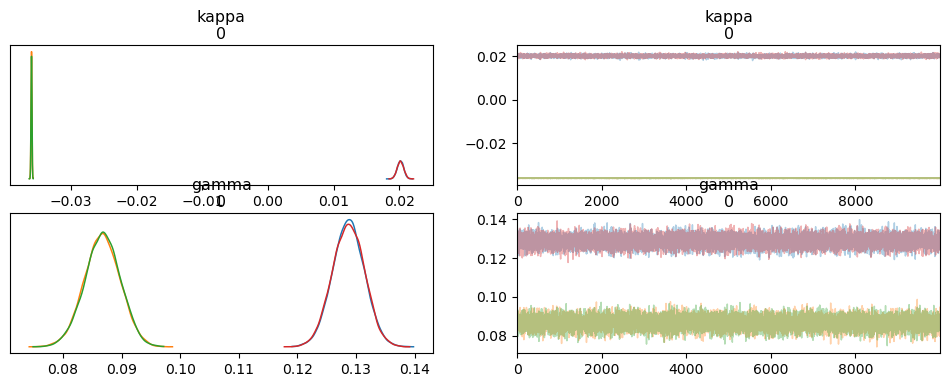

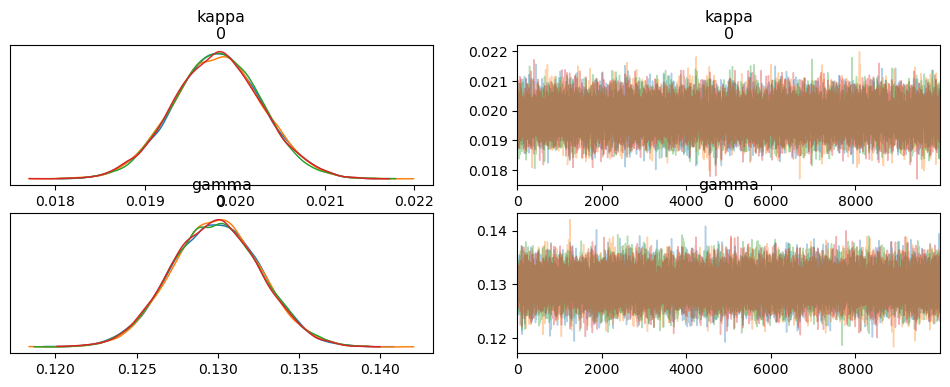

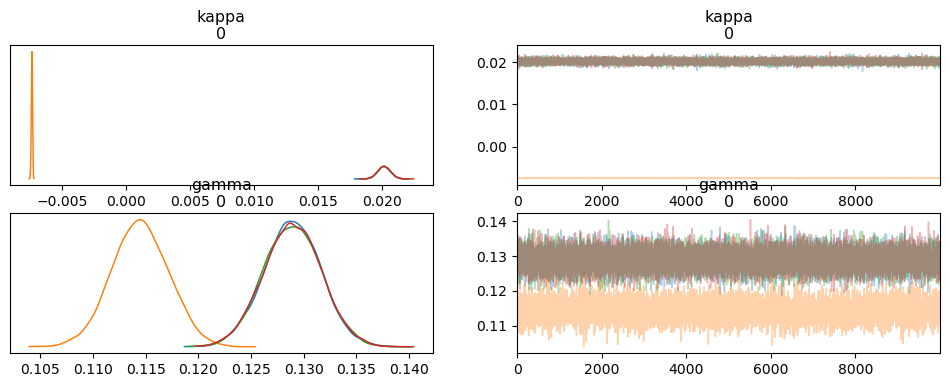

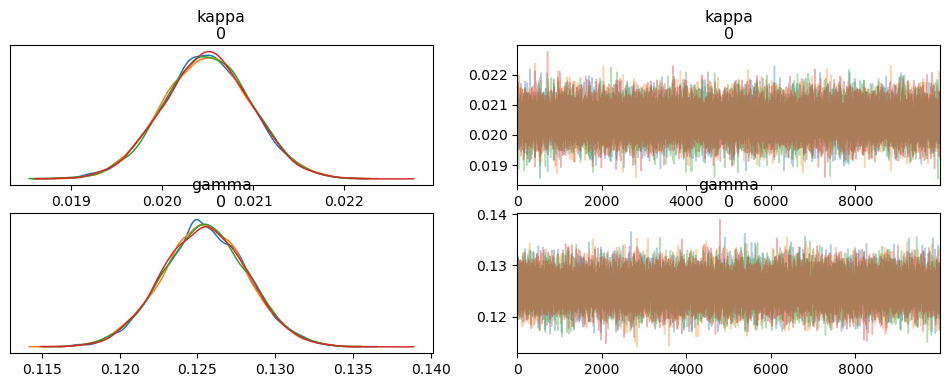

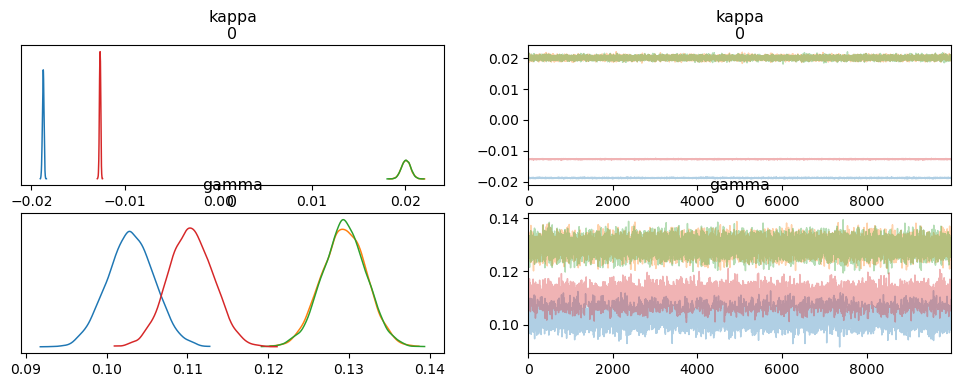

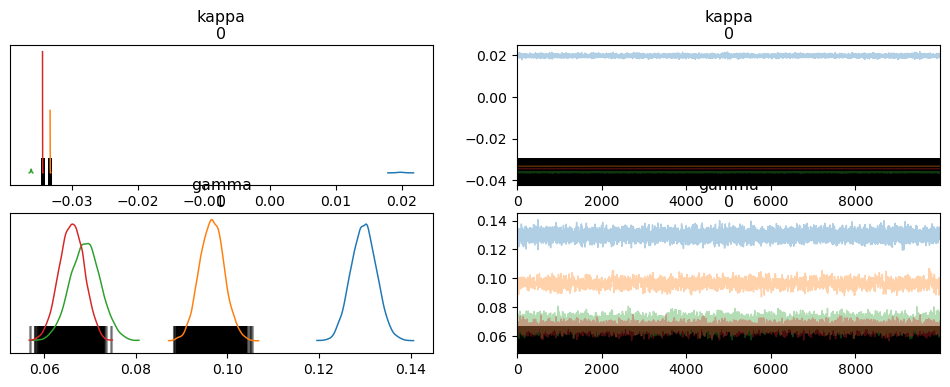

In [50]:

# takes approximately 6-10 ,minutes for 10 subjects

subjects = data['subject'].unique()
nb_subj = subjects.shape[0]
subj_id = np.array(range(nb_subj))
print(subj_id)

for s in subjects:
    print('Working on modeling for subject : {}'.format(s))
    delay_amt = data.loc[data['subject']==s]['cdd_delay_amt'].values
    delay_wait = data.loc[data['subject']==s]['cdd_delay_wait'].values
    immed_amt = data.loc[data['subject']==s]['cdd_immed_amt'].values
    immed_wait = data.loc[data['subject']==s]['cdd_immed_wait'].values
    choices = data.loc[data['subject']==s]['cdd_trial_resp.corr'].values
    
    # We will fit a model for each subject
    with pm.Model() as model_prior:
                            
        # use above mean and stdev to define kappa and gamma, the posterior from the pooled is now our prior
        kappa = pm.Normal('kappa',mu=mu_kappa,sigma=std_kappa,shape=1)
        gamma = pm.Normal('gamma',mu=mu_gamma,sigma=std_gamma,shape=1)
        
        prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma * ( delay_amt/(1+(kappa*delay_wait)) - immed_amt/(1+(kappa*immed_wait)) ))))

        y_1 = pm.Bernoulli('y_1',p=prob,observed=choices)

        trace_prior = pm.sample(10000, tune=10000, cores=4,target_accept=0.9)


    # Call the trace whatever you like. This just saves it. You don't want to run a whole model and then accidentally x-out your window or refresh or something and lose it all!
    az.plot_trace(trace_prior, var_names=["kappa","gamma"],compact=False)
    # This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
    summary= az.summary(trace_prior,round_to=10)
    fn = os.path.join(save_dir,"pool_as_prior_s{}.csv".format(s))
    # Again, call it what you want (yeah - call it what you want tooooo)
    print('Saving to : {}'.format(fn))
    summary.to_csv(fn)